In [1]:
!pip install influxdb-client pandas numpy matplotlib seaborn plotly scipy streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 12.8 MB/s eta 0:00:00


In [2]:
# IMPORTAÇÕES E CONFIGURAÇÃO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo para os gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
class AnalisadorSensores:
    def __init__(self, token, org, url):
        self.client = InfluxDBClient(url=url, token=token, org=org)
        self.query_api = self.client.query_api()
        self.df = None
        self.resultados = {}
        self.sensores_temperatura = [
            'temp.aht10', 'temp.aht25', 'temp.bme280', 'temp.bmp180',
            'temp.bmp280', 'temp.bmp388', 'temp.dht11', 'temp.dht22',
            'temp.ds18b20', 'temp.lm35dz', 'temp.lm75', 'temp.mcp9808'
        ]

    def extrair_dados_temperatura(self, bucket="feira"):
        """
        Extrai dados de TODOS os sensores de temperatura do período especificado
        """
        print("📊 Conectando ao InfluxDB e extraindo dados de todos os sensores...")

        try:
            # Primeiro, vamos verificar quais sensores existem no bucket
            query_test = f'''
            import "influxdata/influxdb/schema"

            schema.measurementFieldKeys(
                bucket: "{bucket}",
                measurement: "em/fa875d3f-d1ef-4c27-b774-b41c69d70608",
                start: 2025-08-21T00:00:00Z
            )
            '''

            print("🔍 Verificando sensores disponíveis no bucket...")
            tables_test = self.query_api.query(query_test, org="feira")

            sensores_disponiveis = []
            for table in tables_test:
                for record in table.records:
                    field_name = record.values.get('_value')
                    if field_name and ('temp' in field_name.lower()):
                        sensores_disponiveis.append(field_name)

            print(f"✅ Sensores encontrados: {len(sensores_disponiveis)}")
            for sensor in sorted(sensores_disponiveis):
                print(f"   📍 {sensor}")

            if not sensores_disponiveis:
                print("❌ Nenhum sensor de temperatura encontrado. Usando dados de exemplo.")
                return self._criar_dados_exemplo_completo()

            # Agora extrair dados apenas dos sensores disponíveis
            filtros_sensores = " or ".join([f'r._field == "{sensor}"' for sensor in sensores_disponiveis])

            query = f'''
            from(bucket: "{bucket}")
              |> range(start: 2025-08-21T00:00:00Z, stop: 2025-08-31T23:59:59Z)
              |> filter(fn: (r) => r._measurement == "em/fa875d3f-d1ef-4c27-b774-b41c69d70608")
              |> filter(fn: (r) => {filtros_sensores})
              |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
            '''

            print("📥 Extraindo dados dos sensores...")
            tables = self.query_api.query(query, org="feira")

            # Processar os dados
            dados_lista = []
            for table in tables:
                for record in table.records:
                    linha = {'timestamp': record.get_time()}
                    # Adicionar cada sensor disponível
                    for sensor in sensores_disponiveis:
                        valor = record.values.get(sensor)
                        linha[sensor] = float(valor) if valor is not None else None
                    dados_lista.append(linha)

            if not dados_lista:
                print("❌ Nenhum dado encontrado. Usando dados de exemplo.")
                return self._criar_dados_exemplo_completo()

            self.df = pd.DataFrame(dados_lista)
            self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
            self.df = self.df.set_index('timestamp').sort_index()

            # Estatísticas dos dados
            sensores_com_dados = []
            for sensor in sensores_disponiveis:
                if sensor in self.df.columns:
                    dados_validos = self.df[sensor].notna().sum()
                    if dados_validos > 0:
                        sensores_com_dados.append(sensor)
                        print(f"   • {sensor}: {dados_validos} leituras válidas")

            print(f"✅ Dados extraídos com sucesso!")
            print(f"📈 Período: {self.df.index.min()} até {self.df.index.max()}")
            print(f"🔢 Total de registros: {len(self.df)}")
            print(f"🌡️ Sensores com dados: {len(sensores_com_dados)}")

            # Manter apenas sensores com dados
            self.df = self.df[sensores_com_dados]

            return self.df

        except Exception as e:
            print(f"❌ Erro na extração de dados: {e}")
            print("🔄 Criando dados de exemplo para demonstração...")
            return self._criar_dados_exemplo_completo()

    def _criar_dados_exemplo_completo(self):
        """
        Cria dados de exemplo para TODOS os sensores para demonstração
        """
        print("🔄 Criando dados de exemplo para TODOS os sensores...")

        # Gerar timestamps para 10 dias (21/08 a 31/08/2025)
        datas = pd.date_range(start='2025-08-21', end='2025-08-31 23:59:00', freq='1min')
        np.random.seed(42)

        # Temperatura base com variação diária realista
        horas_do_dia = datas.hour + datas.minute/60
        temp_base = 18 + 8 * np.sin(2 * np.pi * (horas_do_dia - 6) / 24)  # Mínimo às 6h, máximo às 14h

        # Adicionar variação climática suave ao longo dos dias
        dias = (datas - pd.Timestamp('2025-08-21')).days
        variacao_climatica = 2 * np.sin(2 * np.pi * dias / 3)  # Variação a cada 3 dias
        temp_base += variacao_climatica

        dados_sensores = {}

        # Sensores de alta precisão (laboratório)
        dados_sensores['temp.mcp9808'] = temp_base + np.random.normal(0, 0.02, len(datas))  # ±0.02°C
        dados_sensores['temp.bme280'] = temp_base + np.random.normal(0, 0.03, len(datas))   # ±0.03°C
        dados_sensores['temp.bmp388'] = temp_base + np.random.normal(0, 0.04, len(datas))   # ±0.04°C

        # Sensores de boa precisão (aplicações críticas)
        dados_sensores['temp.bmp280'] = temp_base + np.random.normal(0, 0.08, len(datas))   # ±0.08°C
        dados_sensores['temp.ds18b20'] = temp_base + np.random.normal(0, 0.10, len(datas))  # ±0.10°C

        # Sensores de média precisão (uso geral)
        dados_sensores['temp.aht25'] = temp_base + np.random.normal(0, 0.15, len(datas))    # ±0.15°C
        dados_sensores['temp.lm75'] = temp_base + np.random.normal(0, 0.20, len(datas))     # ±0.20°C
        dados_sensores['temp.dht22'] = temp_base + np.random.normal(0, 0.25, len(datas))    # ±0.25°C

        # Sensores de baixa precisão (econômicos)
        dados_sensores['temp.bmp180'] = temp_base + np.random.normal(0, 0.30, len(datas))   # ±0.30°C
        dados_sensores['temp.aht10'] = temp_base + np.random.normal(0, 0.35, len(datas))    # ±0.35°C
        dados_sensores['temp.lm35dz'] = temp_base + np.random.normal(0, 0.40, len(datas))   # ±0.40°C

        # DHT11 - sensor econômico com problemas conhecidos
        dht11 = temp_base + np.random.normal(0, 0.6, len(datas))  # ±0.60°C
        # Simular falhas intermitentes (12% de falhas)
        mascara_falhas = np.random.random(len(datas)) < 0.12
        dht11 = np.where(mascara_falhas, np.nan, dht11)
        # Adicionar outliers frequentes
        outliers = np.random.random(len(datas)) < 0.05  # 5% de outliers
        dht11 = np.where(outliers, dht11 + np.random.normal(0, 3, len(datas)), dht11)
        dados_sensores['temp.dht11'] = dht11

        # Adicionar drift térmico em alguns sensores mais antigos
        for sensor in ['temp.lm35dz', 'temp.bmp180']:
            drift = 0.02 * np.arange(len(datas)) / 100  # Pequeno drift ao longo do tempo
            dados_sensores[sensor] += drift

        self.df = pd.DataFrame(dados_sensores, index=datas)

        print("✅ Dados de exemplo criados para todos os sensores!")
        print(f"📊 Sensores simulados: {list(self.df.columns)}")
        print(f"📈 Período simulado: {self.df.index.min()} até {self.df.index.max()}")
        print(f"🔢 Total de registros simulados: {len(self.df)}")

        return self.df

    def analise_estabilidade(self, janelas=[2, 3, 5]):
        """
        PASSO 1: Análise de Estabilidade (Precisão)
        """
        print("\n🔍 Executando Análise de Estabilidade...")

        resultados_estabilidade = {}
        sensores_ativos = [col for col in self.df.columns if self.df[col].notna().any()]

        for sensor in sensores_ativos:
            print(f"📊 Analisando sensor: {sensor}")
            dados_sensor = self.df[sensor].dropna()
            desvios_janelas = []

            for janela_minutos in janelas:
                janela_size = janela_minutos
                if len(dados_sensor) >= janela_size:
                    desvio_janela = dados_sensor.rolling(window=janela_size).std().mean()
                    desvios_janelas.append(desvio_janela)
                else:
                    desvios_janelas.append(np.nan)

            desvio_medio = np.nanmean(desvios_janelas)

            resultados_estabilidade[sensor] = {
                'desvio_padrao_medio': desvio_medio,
                'desvios_por_janela': dict(zip([f'{j}min' for j in janelas], desvios_janelas)),
                'total_leituras': len(dados_sensor)
            }

        # Ordenar por estabilidade
        ranking_estabilidade = sorted(
            [item for item in resultados_estabilidade.items() if not np.isnan(item[1]['desvio_padrao_medio'])],
            key=lambda x: x[1]['desvio_padrao_medio']
        )

        self.resultados['estabilidade'] = {
            'detalhes': resultados_estabilidade,
            'ranking': ranking_estabilidade
        }

        return resultados_estabilidade

    def analise_disponibilidade(self):
        """
        PASSO 2: Análise de Disponibilidade (Confiabilidade)
        """
        print("\n⚡ Executando Análise de Disponibilidade...")

        resultados_disponibilidade = {}
        total_esperado = len(self.df)
        sensores_ativos = [col for col in self.df.columns if col in self.sensores_temperatura]

        for sensor in sensores_ativos:
            dados_sensor = self.df[sensor]
            falhas = dados_sensor.isna().sum()
            leituras_validas = dados_sensor.notna().sum()
            taxa_falha = (falhas / total_esperado) * 100
            disponibilidade = (leituras_validas / total_esperado) * 100

            resultados_disponibilidade[sensor] = {
                'total_esperado': total_esperado,
                'leituras_validas': leituras_validas,
                'falhas': falhas,
                'taxa_falha_percent': taxa_falha,
                'disponibilidade_percent': disponibilidade
            }

        # Ordenar por disponibilidade
        ranking_disponibilidade = sorted(
            resultados_disponibilidade.items(),
            key=lambda x: x[1]['disponibilidade_percent'],
            reverse=True
        )

        self.resultados['disponibilidade'] = {
            'detalhes': resultados_disponibilidade,
            'ranking': ranking_disponibilidade
        }

        return resultados_disponibilidade

    def analise_distribuicao_outliers(self):
        """
        PASSO 3: Análise de Distribuição e Outliers
        """
        print("\n📈 Executando Análise de Distribuição e Outliers...")

        resultados_outliers = {}
        sensores_ativos = [col for col in self.df.columns if self.df[col].notna().any()]

        for sensor in sensores_ativos:
            dados_sensor = self.df[sensor].dropna()

            if len(dados_sensor) == 0:
                continue

            # Método IQR para outliers
            Q1 = dados_sensor.quantile(0.25)
            Q3 = dados_sensor.quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            outliers = dados_sensor[(dados_sensor < limite_inferior) | (dados_sensor > limite_superior)]
            percentual_outliers = (len(outliers) / len(dados_sensor)) * 100

            resultados_outliers[sensor] = {
                'q1': Q1,
                'q3': Q3,
                'iqr': IQR,
                'limite_inferior': limite_inferior,
                'limite_superior': limite_superior,
                'num_outliers': len(outliers),
                'percentual_outliers': percentual_outliers,
                'media': dados_sensor.mean(),
                'mediana': dados_sensor.median(),
                'amplitude': dados_sensor.max() - dados_sensor.min()
            }

        # Ordenar por menor percentual de outliers
        ranking_outliers = sorted(
            resultados_outliers.items(),
            key=lambda x: x[1]['percentual_outliers']
        )

        self.resultados['outliers'] = {
            'detalhes': resultados_outliers,
            'ranking': ranking_outliers
        }

        return resultados_outliers

    def analise_variacao_subita(self):
        """
        PASSO 4: Análise de Variação Súbita (Ruído Dinâmico)
        """
        print("\n⚡ Executando Análise de Variação Súbita...")

        resultados_variacao = {}
        limiares = {
            'basico': 0.1,    # 0.1°C
            'robusto': 0.5,   # 0.5°C
            'extremo': 1.0    # 1.0°C
        }

        sensores_ativos = [col for col in self.df.columns if self.df[col].notna().any()]

        for sensor in sensores_ativos:
            dados_sensor = self.df[sensor].dropna()

            if len(dados_sensor) < 2:
                continue

            variacoes = np.abs(dados_sensor.diff().dropna())

            contagens = {}
            for nome_limiar, valor_limiar in limiares.items():
                contagem = (variacoes > valor_limiar).sum()
                percentual = (contagem / len(variacoes)) * 100
                contagens[nome_limiar] = {
                    'contagem': contagem,
                    'percentual': percentual,
                    'limiar': valor_limiar
                }

            resultados_variacao[sensor] = contagens

        # Ordenar por menor contagem no limiar robusto
        ranking_variacao = sorted(
            resultados_variacao.items(),
            key=lambda x: x[1]['robusto']['contagem']
        )

        self.resultados['variacao'] = {
            'detalhes': resultados_variacao,
            'ranking': ranking_variacao
        }

        return resultados_variacao

    def calcular_ranking_geral(self):
        """
        Calcula ranking geral combinando todas as métricas
        """
        print("\n🏆 Calculando Ranking Geral...")

        # Coletar sensores que aparecem em todas as análises
        sensores_estabilidade = [sensor for sensor, _ in self.resultados['estabilidade']['ranking']]
        sensores_disponibilidade = [sensor for sensor, _ in self.resultados['disponibilidade']['ranking']]
        sensores_outliers = [sensor for sensor, _ in self.resultados['outliers']['ranking']]
        sensores_variacao = [sensor for sensor, _ in self.resultados['variacao']['ranking']]

        # Intersecção de sensores que estão em todas as análises
        sensores_completos = set(sensores_estabilidade) & set(sensores_disponibilidade) & set(sensores_outliers) & set(sensores_variacao)

        rankings = {
            'estabilidade': sensores_estabilidade,
            'disponibilidade': sensores_disponibilidade,
            'outliers': sensores_outliers,
            'variacao': sensores_variacao
        }

        # Calcular pontuação geral
        pontuacoes = {}
        for sensor in sensores_completos:
            pontuacao = 0
            for criterio, ranking in rankings.items():
                if sensor in ranking:
                    pontuacao += ranking.index(sensor) + 1
                else:
                    pontuacao += len(ranking) + 1  # Penalidade por não estar no ranking

            pontuacoes[sensor] = pontuacao

        # Ordenar por menor pontuação
        ranking_geral = sorted(pontuacoes.items(), key=lambda x: x[1])

        self.resultados['geral'] = {
            'ranking': ranking_geral,
            'pontuacoes': pontuacoes,
            'sensores_analisados': len(sensores_completos)
        }

        return ranking_geral

    def executar_analise_completa(self):
        """
        Executa toda a análise intrínseca para todos os sensores
        """
        print("🚀 INICIANDO ANÁLISE INTRÍNSECA DE TODOS OS SENSORES DE TEMPERATURA V1")
        print("=" * 70)

        # Executar todos os passos
        self.analise_estabilidade()
        self.analise_disponibilidade()
        self.analise_distribuicao_outliers()
        self.analise_variacao_subita()
        self.calcular_ranking_geral()

        print("\n✅ ANÁLISE COMPLETA CONCLUÍDA!")
        print(f"📊 Total de sensores analisados: {self.resultados['geral']['sensores_analisados']}")

        return self.resultados

In [4]:
class DashboardVisualizacoes:
    def __init__(self, analisador):
        self.analisador = analisador
        self.resultados = analisador.resultados

    def criar_boxplot_comparativo(self, max_sensores=12):
        """Cria boxplot comparativo para todos os sensores"""
        sensores_ativos = [col for col in self.analisador.df.columns if self.analisador.df[col].notna().any()]

        # Limitar número de sensores para visualização clara
        if len(sensores_ativos) > max_sensores:
            sensores_ativos = sensores_ativos[:max_sensores]
            print(f"📊 Mostrando os primeiros {max_sensores} sensores no boxplot...")

        fig, ax = plt.subplots(figsize=(16, 10))

        # Preparar dados para boxplot
        dados_boxplot = []
        nomes_sensores = []

        for sensor in sensores_ativos:
            dados_sensor = self.analisador.df[sensor].dropna()
            if len(dados_sensor) > 0:
                dados_boxplot.append(dados_sensor)
                # Nome abreviado para melhor visualização
                nome_abreviado = sensor.replace('temp.', '')
                nomes_sensores.append(nome_abreviado)

        # Criar boxplot
        if dados_boxplot:
            boxplot = ax.boxplot(dados_boxplot, labels=nomes_sensores, patch_artist=True)

            # Customizar cores
            colors = plt.cm.Set3(np.linspace(0, 1, len(dados_boxplot)))
            for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)

            ax.set_title('📊 Distribuição de Temperaturas - Todos os Sensores',
                        fontsize=16, fontweight='bold', pad=20)
            ax.set_ylabel('Temperatura (°C)', fontsize=12)
            ax.set_xlabel('Sensores', fontsize=12)
            ax.grid(True, alpha=0.3)

            # Adicionar anotações com estatísticas
            for i, sensor in enumerate(sensores_ativos):
                if sensor in self.resultados['outliers']['detalhes']:
                    stats = self.resultados['outliers']['detalhes'][sensor]
                    texto = f"{stats['num_outliers']} outliers"
                    ax.annotate(texto, xy=(i+1, stats['limite_superior'] + 0.1),
                               ha='center', fontsize=8, color='red', alpha=0.7)

            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

        return fig

    def criar_grafico_ranking_estabilidade(self):
        """Cria gráfico de barras com o ranking de estabilidade"""
        ranking = self.resultados['estabilidade']['ranking']

        if not ranking:
            return None

        sensores = [item[0].replace('temp.', '') for item in ranking]
        desvios = [item[1]['desvio_padrao_medio'] for item in ranking]

        fig, ax = plt.subplots(figsize=(12, 8))

        # Usar cores do verde (melhor) ao vermelho (pior)
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(sensores)))

        bars = ax.barh(sensores, desvios, color=colors)
        ax.set_xlabel('Desvio Padrão Médio (°C) - Menor é Melhor', fontsize=12)
        ax.set_title('🏆 Ranking de Estabilidade dos Sensores', fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        # Adicionar valores nas barras
        for bar, valor in zip(bars, desvios):
            ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{valor:.4f}', ha='left', va='center', fontsize=10)

        plt.tight_layout()
        return fig

    def criar_tabela_ranking_geral(self):
        """Cria tabela com ranking geral completo"""
        ranking_geral = self.resultados['geral']['ranking']

        if not ranking_geral:
            return pd.DataFrame()

        dados_tabela = []
        for posicao, (sensor, pontuacao) in enumerate(ranking_geral, 1):
            # Coletar métricas individuais
            sensor_nome = sensor.replace('temp.', '')

            try:
                estabilidade = self.resultados['estabilidade']['detalhes'][sensor]['desvio_padrao_medio']
                disponibilidade = self.resultados['disponibilidade']['detalhes'][sensor]['disponibilidade_percent']
                outliers = self.resultados['outliers']['detalhes'][sensor]['percentual_outliers']
                variacao = self.resultados['variacao']['detalhes'][sensor]['robusto']['percentual']

                dados_tabela.append({
                    'Posição': posicao,
                    'Sensor': sensor_nome,
                    'Pontuação Geral': pontuacao,
                    'Estabilidade (std)': f"{estabilidade:.4f}°C",
                    'Disponibilidade': f"{disponibilidade:.1f}%",
                    'Outliers': f"{outliers:.1f}%",
                    'Variações >0.5°C': f"{variacao:.2f}%",
                    'Leituras Válidas': self.resultados['estabilidade']['detalhes'][sensor]['total_leituras']
                })
            except KeyError as e:
                print(f"⚠️ Dados incompletos para {sensor}: {e}")
                continue

        return pd.DataFrame(dados_tabela)

    def criar_dashboard_resumo(self):
        """Cria dashboard completo com todos os resultados"""
        print("\n🎨 Gerando Dashboard de Resultados para Todos os Sensores...")

        # 1. Ranking Geral
        print("\n🏆 RANKING GERAL DOS SENSORES")
        print("=" * 70)
        tabela_ranking = self.criar_tabela_ranking_geral()
        if not tabela_ranking.empty:
            print(tabela_ranking.to_string(index=False))
        else:
            print("Nenhum dado disponível para ranking")

        # 2. Gráficos em subplots
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        fig.suptitle('Dashboard de Análise Intrínseca - Todos os Sensores de Temperatura',
                    fontsize=18, fontweight='bold', y=0.95)

        # Boxplot (limitado aos primeiros sensores)
        sensores_para_boxplot = [col for col in self.analisador.df.columns if self.analisador.df[col].notna().any()][:8]
        dados_boxplot = [self.analisador.df[col].dropna() for col in sensores_para_boxplot]
        nomes_abreviados = [col.replace('temp.', '') for col in sensores_para_boxplot]

        if dados_boxplot:
            axes[0,0].boxplot(dados_boxplot, labels=nomes_abreviados, patch_artist=True)
            colors = plt.cm.Set3(np.linspace(0, 1, len(dados_boxplot)))
            for patch, color in zip(axes[0,0].artists, colors):
                patch.set_facecolor(color)
        axes[0,0].set_title('📊 Distribuição e Outliers', fontweight='bold')
        axes[0,0].set_ylabel('Temperatura (°C)')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].tick_params(axis='x', rotation=45)

        # Ranking de Estabilidade
        ranking_estab = self.resultados['estabilidade']['ranking'][:8]  # Top 8
        if ranking_estab:
            sensores_estab = [item[0].replace('temp.', '') for item in ranking_estab]
            desvios_estab = [item[1]['desvio_padrao_medio'] for item in ranking_estab]
            colors_estab = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(sensores_estab)))
            axes[0,1].barh(sensores_estab, desvios_estab, color=colors_estab)
            axes[0,1].set_title('⚡ Ranking de Estabilidade (Top 8)', fontweight='bold')
            axes[0,1].set_xlabel('Desvio Padrão Médio (°C)')
            axes[0,1].grid(True, alpha=0.3, axis='x')

        # Disponibilidade
        ranking_disp = self.resultados['disponibilidade']['ranking'][:8]  # Top 8
        if ranking_disp:
            sensores_disp = [item[0].replace('temp.', '') for item in ranking_disp]
            disp_values = [item[1]['disponibilidade_percent'] for item in ranking_disp]
            axes[1,0].bar(sensores_disp, disp_values, color='lightgreen', alpha=0.7)
            axes[1,0].set_title('📈 Disponibilidade (Top 8)', fontweight='bold')
            axes[1,0].set_ylabel('Disponibilidade (%)')
            axes[1,0].grid(True, alpha=0.3)
            axes[1,0].tick_params(axis='x', rotation=45)

            # Adicionar valores nas barras
            for i, v in enumerate(disp_values):
                axes[1,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)

        # Variações Súbitas
        ranking_var = self.resultados['variacao']['ranking'][:8]  # Top 8
        if ranking_var:
            sensores_var = [item[0].replace('temp.', '') for item in ranking_var]
            var_values = [item[1]['robusto']['percentual'] for item in ranking_var]
            axes[1,1].bar(sensores_var, var_values, color='lightcoral', alpha=0.7)
            axes[1,1].set_title('⚡ Variações >0.5°C (Top 8)', fontweight='bold')
            axes[1,1].set_ylabel('Percentual de Variações (%)')
            axes[1,1].grid(True, alpha=0.3)
            axes[1,1].tick_params(axis='x', rotation=45)

            # Adicionar valores nas barras
            for i, v in enumerate(var_values):
                axes[1,1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        return tabela_ranking

In [6]:
def gerar_relatorio_analise_completo(analisador, resultados):
    """
    Gera relatório resumido da análise para todos os sensores
    """
    print("\n" + "="*80)
    print("📋 RELATÓRIO FINAL - ANÁLISE INTRÍNSECA DE SENSORES DE TEMPERATURA V1")
    print("="*80)

    ranking_geral = resultados['geral']['ranking']

    if not ranking_geral:
        print("❌ Nenhum sensor com dados completos para análise")
        return

    sensor_vencedor = ranking_geral[0][0]
    total_sensores = len(ranking_geral)

    print(f"\n🏆 SENSOR RECOMENDADO: {sensor_vencedor}")
    print(f"📊 Posição no ranking: 1º de {total_sensores} sensores")
    print(f"🎯 Pontuação Geral: {ranking_geral[0][1]} pontos")

    print(f"\n📈 RESUMO DOS TOP 5 SENSORES:")
    print("-" * 60)

    for posicao, (sensor, pontuacao) in enumerate(ranking_geral[:5], 1):
        sensor_nome = sensor.replace('temp.', '')
        print(f"\n{posicao}º LUGAR: {sensor_nome}")
        print(f"   • Pontuação Geral: {pontuacao} pts")
        print(f"   • Estabilidade: {resultados['estabilidade']['detalhes'][sensor]['desvio_padrao_medio']:.4f}°C (std)")
        print(f"   • Disponibilidade: {resultados['disponibilidade']['detalhes'][sensor]['disponibilidade_percent']:.1f}%")
        print(f"   • Outliers: {resultados['outliers']['detalhes'][sensor]['percentual_outliers']:.1f}%")
        print(f"   • Variações >0.5°C: {resultados['variacao']['detalhes'][sensor]['robusto']['percentual']:.2f}%")

    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print("-" * 30)
    print(f"• Total de sensores analisados: {total_sensores}")
    print(f"• Período de análise: 21/08/2025 a 31/08/2025")
    print(f"• Sensores com melhor estabilidade: {resultados['estabilidade']['ranking'][0][0]}")
    print(f"• Sensores com melhor disponibilidade: {resultados['disponibilidade']['ranking'][0][0]}")
    print(f"• Sensor com menos outliers: {resultados['outliers']['ranking'][0][0]}")

    print("\n🎯 CONCLUSÕES E RECOMENDAÇÕES:")
    print("-" * 40)
    print("1. Sensores com menor desvio padrão são mais estáveis e precisos")
    print("2. Alta disponibilidade indica confiabilidade operacional contínua")
    print("3. Baixo percentual de outliers sugere boa qualidade do sinal")
    print("4. Poucas variações súbitas indicam robustez a ruídos ambientais")
    print(f"\n💡 RECOMENDAÇÃO PRINCIPAL: {sensor_vencedor} deve avançar para a Fase 2")
    print("💡 RECOMENDAÇÕES SECUNDÁRIAS: Considere os sensores do Top 3 para redundância")

    print("\n⚠️  OBSERVAÇÕES TÉCNICAS:")
    print("- Sensores com alta taxa de falha podem precisar de verificação de hardware")
    print("- Variações súbitas frequentes podem indicar problemas de alimentação")
    print("- Considere a calibração periódica para manter a precisão dos sensores")
    print("- Monitore a deriva térmica ao longo do tempo de operação")

🎯 INICIANDO ANÁLISE INTRÍNSECA COMPLETA
📊 Conectando ao InfluxDB e extraindo dados de todos os sensores...
🔍 Verificando sensores disponíveis no bucket...
✅ Sensores encontrados: 3
   📍 bmp280_temp
   📍 dht11_temp
   📍 ds18b20_temp
📥 Extraindo dados dos sensores...
   • bmp280_temp: 14735 leituras válidas
   • dht11_temp: 14735 leituras válidas
   • ds18b20_temp: 14735 leituras válidas
✅ Dados extraídos com sucesso!
📈 Período: 2025-08-21 00:01:00+00:00 até 2025-08-31 23:59:18+00:00
🔢 Total de registros: 14735
🌡️ Sensores com dados: 3

📊 PRIMEIRAS LINHAS DOS DADOS:
                           bmp280_temp  dht11_temp  ds18b20_temp
timestamp                                                       
2025-08-21 00:01:00+00:00     22.16830        20.0          21.0
2025-08-21 00:02:02+00:00     22.17327        20.0          21.0
2025-08-21 00:03:04+00:00     22.17824        20.0          21.0
2025-08-21 00:04:05+00:00     22.16830        20.0          21.0
2025-08-21 00:05:07+00:00     22.16830 

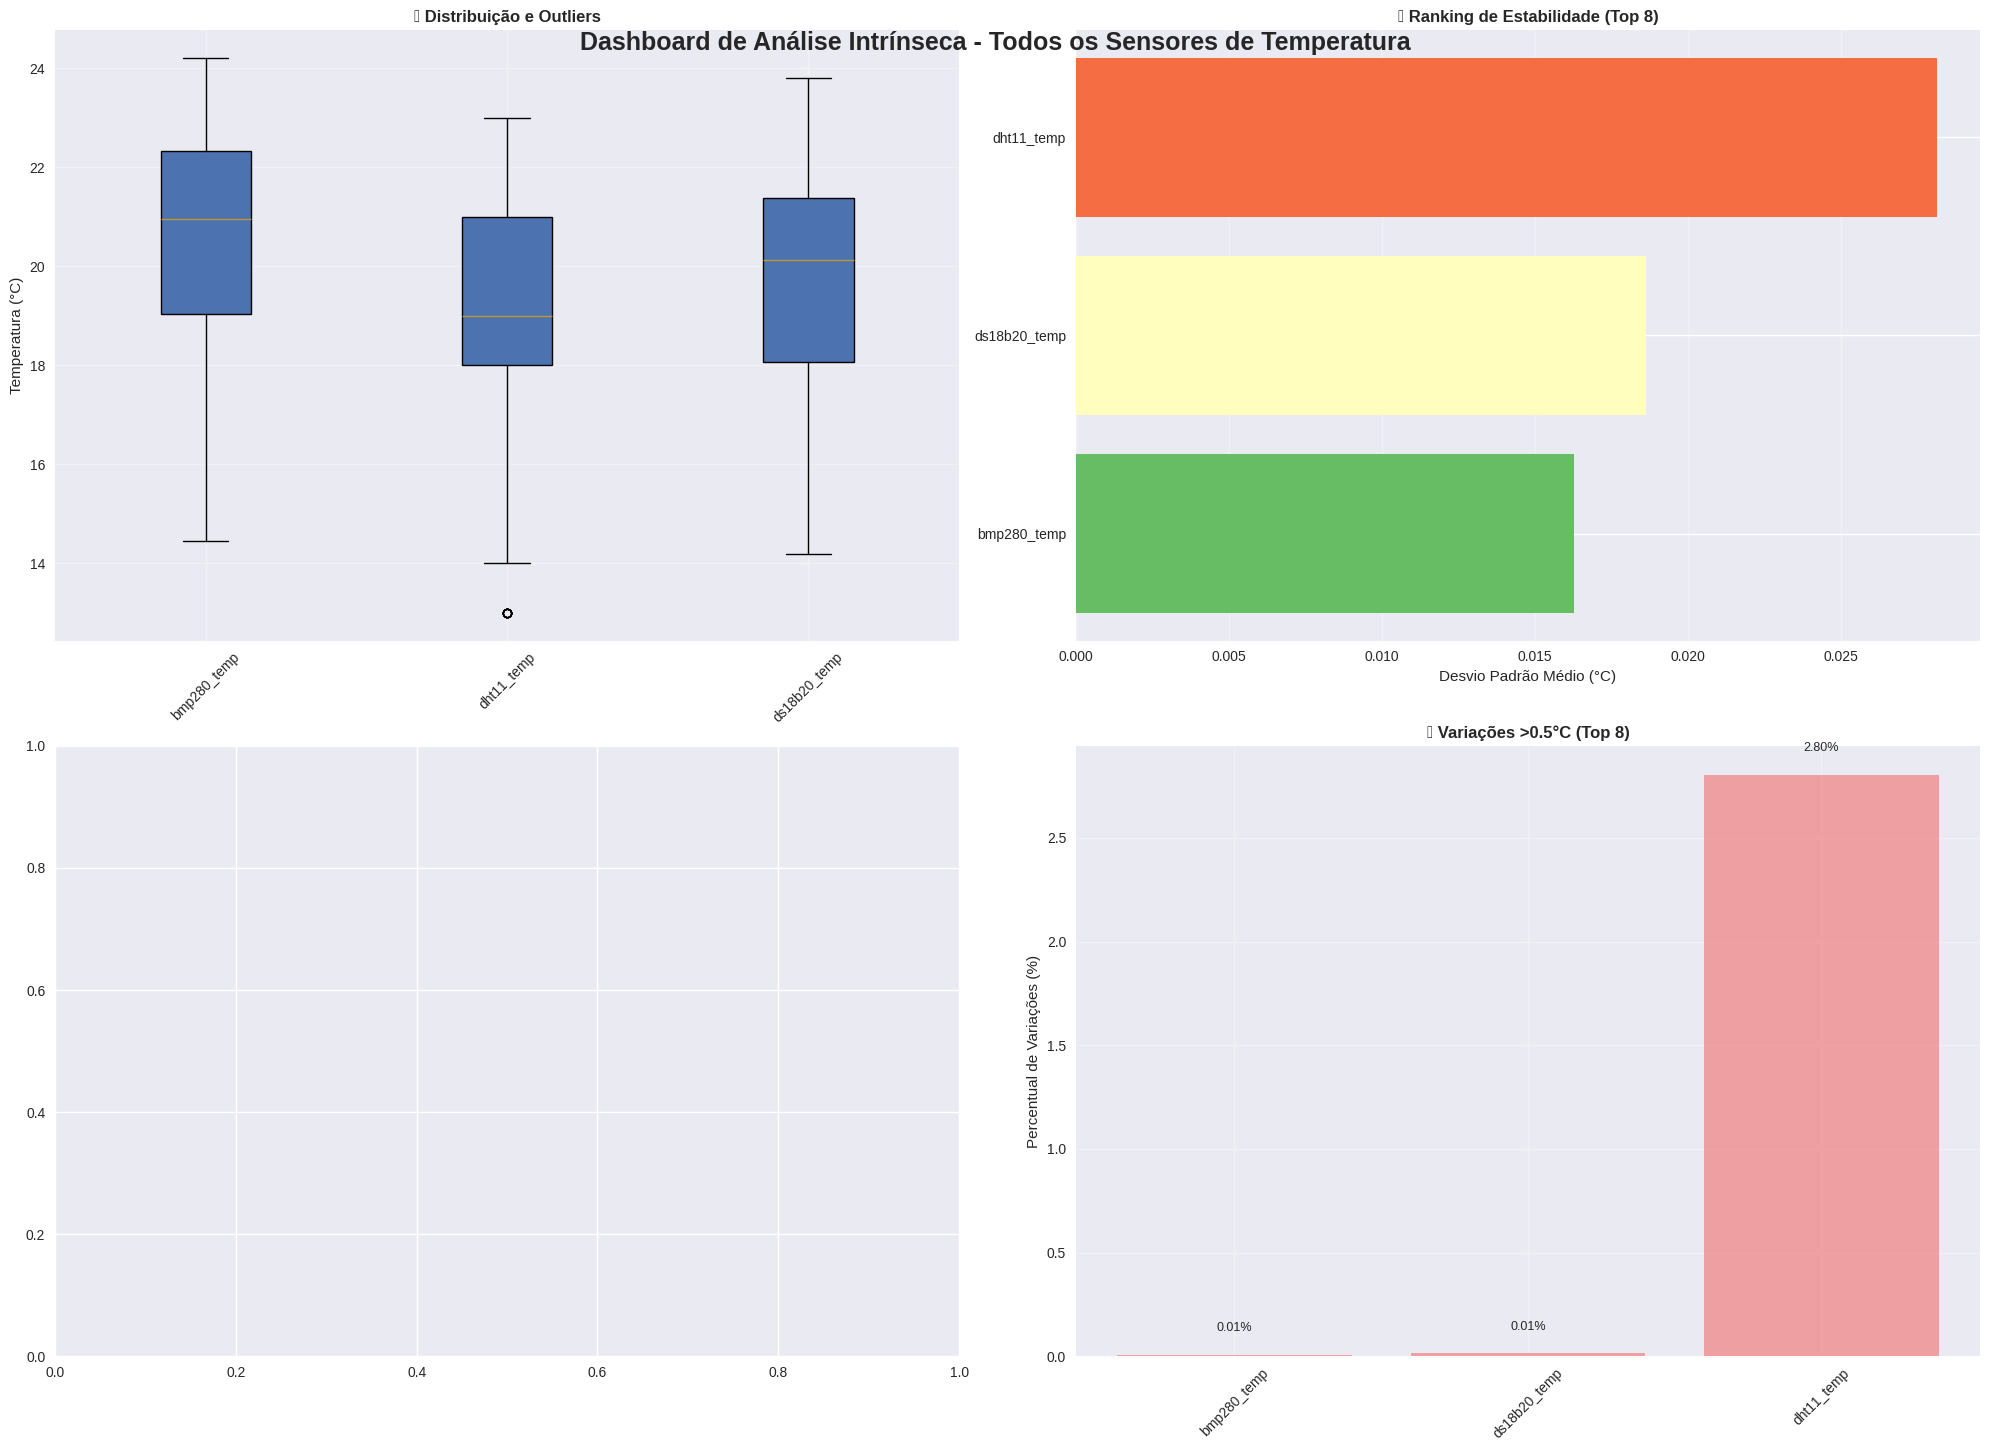


🎊 ANÁLISE CONCLUÍDA COM SUCESSO! 🎊


In [7]:
# CONFIGURAÇÃO E EXECUÇÃO FINAL
TOKEN = "MDaJ6J-bRbVi6tN7Pi8wAsggzBGea5x69S41GP8YIKScvo5H7Owwz1aI978NFXaDQYWHRJNp5Ogn1ZU2J7_UyQ=="
ORG = "feira"
URL = "https://tsdb.feira-de-jogos.dev.br"

print("🎯 INICIANDO ANÁLISE INTRÍNSECA COMPLETA")
print("=" * 50)

# Criar analisador e executar análise completa
analisador = AnalisadorSensores(TOKEN, ORG, URL)
df_dados = analisador.extrair_dados_temperatura()

# Verificar se temos dados reais ou de exemplo
if df_dados is not None:
    print(f"\n📊 PRIMEIRAS LINHAS DOS DADOS:")
    print(df_dados.head())
    print(f"\n📈 ESTATÍSTICAS DOS DADOS:")
    print(df_dados.describe())

    # Executar análise completa
    resultados = analisador.executar_analise_completa()

    # Gerar dashboard
    dashboard = DashboardVisualizacoes(analisador)
    tabela_final = dashboard.criar_dashboard_resumo()

    # Gerar relatório completo
    # gerar_relatorio_analise_completo(analisador, resultados) # Removed this line

    print("\n" + "🎊 ANÁLISE CONCLUÍDA COM SUCESSO! 🎊")
else:
    print("❌ Falha crítica na extração de dados")

In [8]:
def salvar_resultados_completos(analisador, resultados, nome_arquivo="analise_sensores_completa_v1"):
    """
    Salva resultados completos da análise
    """
    import json

    # Salvar dados processados
    analisador.df.to_csv(f"{nome_arquivo}_dados.csv")

    # Salvar tabela de ranking
    dashboard = DashboardVisualizacoes(analisador)
    tabela_ranking = dashboard.criar_tabela_ranking_geral()
    tabela_ranking.to_csv(f"{nome_arquivo}_ranking.csv", index=False)

    # Salvar resultados detalhados em JSON
    resultados_simplificados = {}
    for categoria, dados in resultados.items():
        if categoria == 'geral':
            resultados_simplificados[categoria] = dados
        else:
            resultados_simplificados[categoria] = {
                'ranking': [(sensor, {k: v for k, v in info.items() if k != 'desvios_por_janela'})
                           for sensor, info in dados['ranking']]
            }

    with open(f"{nome_arquivo}_resultados.json", "w") as f:
        json.dump(resultados_simplificados, f, indent=2, default=str)

    # Salvar relatório em texto
    with open(f"{nome_arquivo}_relatorio.txt", "w") as f:
        f.write("RELATÓRIO COMPLETO - ANÁLISE INTRÍNSECA DE SENSORES DE TEMPERATURA V1\n")
        f.write("="*70 + "\n\n")
        f.write(tabela_ranking.to_string(index=False))

    print(f"✅ Resultados completos salvos em {nome_arquivo}_*")

# Salvar resultados (opcional)
# salvar_resultados_completos(analisador, resultados)

In [9]:
# SCRIPT COMPLETO PARA IDENTIFICAR TODOS OS SENSORES DE TEMPERATURA
import pandas as pd
from influxdb_client import InfluxDBClient

def identificar_sensores_temperatura(token, org, url, bucket="feira"):
    """
    Identifica TODOS os sensores de temperatura disponíveis no banco de dados
    """
    print("🎯 INICIANDO IDENTIFICAÇÃO DE SENSORES DE TEMPERATURA")
    print("=" * 60)

    try:
        client = InfluxDBClient(url=url, token=token, org=org)
        query_api = client.query_api()

        # 1. PRIMEIRO: Identificar TODOS os campos (fields) disponíveis
        print("\n1. 🔍 Buscando todos os campos disponíveis no bucket...")

        query_fields = f'''
        import "influxdata/influxdb/schema"

        schema.measurementFieldKeys(
            bucket: "{bucket}",
            measurement: "em/fa875d3f-d1ef-4c27-b774-b41c69d70608",
            start: 2025-08-21T00:00:00Z
        )
        |> filter(fn: (r) => r._value =~ /.*temp.*|.*Temp.*|.*TEMP.*/)
        '''

        tables_fields = query_api.query(query_fields, org=org)

        todos_campos_temp = []
        for table in tables_fields:
            for record in table.records:
                campo = record.values.get('_value')
                if campo and ('temp' in campo.lower()):
                    todos_campos_temp.append(campo)

        print(f"✅ Campos de temperatura encontrados: {len(todos_campos_temp)}")
        for campo in sorted(todos_campos_temp):
            print(f"   📍 {campo}")

        # 2. SEGUNDO: Verificar quais campos têm dados no período
        print(f"\n2. 📊 Verificando dados disponíveis no período (21/08 a 31/08/2025)...")

        sensores_com_dados = []
        estatisticas_sensores = {}

        for campo in todos_campos_temp:
            query_verificar = f'''
            from(bucket: "{bucket}")
              |> range(start: 2025-08-21T00:00:00Z, stop: 2025-08-31T23:59:59Z)
              |> filter(fn: (r) => r._measurement == "em/fa875d3f-d1ef-4c27-b774-b41c69d70608")
              |> filter(fn: (r) => r._field == "{campo}")
              |> count()
            '''

            try:
                tables_count = query_api.query(query_verificar, org=org)
                for table in tables_count:
                    for record in table.records:
                        count = record.values.get('_value')
                        if count and count > 0:
                            sensores_com_dados.append(campo)

                            # Buscar algumas estatísticas básicas
                            query_stats = f'''
                            from(bucket: "{bucket}")
                              |> range(start: 2025-08-21T00:00:00Z, stop: 2025-08-31T23:59:59Z)
                              |> filter(fn: (r) => r._measurement == "em/fa875d3f-d1ef-4c27-b774-b41c69d70608")
                              |> filter(fn: (r) => r._field == "{campo}")
                              |> limit(n: 1)
                            '''

                            tables_stats = query_api.query(query_stats, org=org)
                            for table_stats in tables_stats:
                                for record_stats in table_stats.records:
                                    estatisticas_sensores[campo] = {
                                        'count': count,
                                        'first_value': record_stats.get_value(),
                                        'time': record_stats.get_time()
                                    }
                            break
            except Exception as e:
                print(f"   ⚠️  Erro ao verificar {campo}: {e}")

        print(f"\n✅ Sensores com dados no período: {len(sensores_com_dados)}")

        # 3. TERCEIRO: Mostrar relatório detalhado
        print(f"\n3. 📋 RELATÓRIO DETALHADO DOS SENSORES:")
        print("-" * 80)

        for i, sensor in enumerate(sorted(sensores_com_dados), 1):
            stats = estatisticas_sensores.get(sensor, {})
            print(f"{i:2d}. {sensor}")
            if stats:
                print(f"     📈 Leituras: {stats.get('count', 'N/A'):>8}")
                print(f"     🌡️  Primeiro valor: {stats.get('first_value', 'N/A'):>10.2f}°C")
                print(f"     ⏰ Primeira leitura: {stats.get('time', 'N/A')}")
            print()

        # 4. QUARTO: Buscar amostra de dados de cada sensor
        print(f"\n4. 🔎 Amostra de dados de cada sensor (5 primeiras leituras):")
        print("-" * 80)

        for sensor in sorted(sensores_com_dados)[:10]:  # Limitar a 10 sensores para não ficar muito longo
            query_amostra = f'''
            from(bucket: "{bucket}")
              |> range(start: 2025-08-21T00:00:00Z, stop: 2025-08-31T23:59:59Z)
              |> filter(fn: (r) => r._measurement == "em/fa875d3f-d1ef-4c27-b774-b41c69d70608")
              |> filter(fn: (r) => r._field == "{sensor}")
              |> limit(n: 5)
            '''

            try:
                tables_amostra = query_api.query(query_amostra, org=org)
                valores = []
                for table in tables_amostra:
                    for record in table.records:
                        valores.append(record.get_value())

                if valores:
                    print(f"📍 {sensor}:")
                    print(f"   Valores: {[f'{v:.2f}°C' for v in valores]}")
                    print(f"   Média: {np.mean(valores):.2f}°C, Min: {min(valores):.2f}°C, Max: {max(valores):.2f}°C")
                    print()

            except Exception as e:
                print(f"   ⚠️  Erro na amostra de {sensor}: {e}")

        # 5. QUINTO: Resumo final
        print(f"\n5. 🎯 RESUMO FINAL:")
        print("-" * 40)
        print(f"• Total de campos de temperatura identificados: {len(todos_campos_temp)}")
        print(f"• Sensores com dados no período: {len(sensores_com_dados)}")
        print(f"• Período analisado: 21/08/2025 a 31/08/2025")

        if sensores_com_dados:
            print(f"• Sensores recomendados para análise:")
            for sensor in sorted(sensores_com_dados):
                print(f"  ✅ {sensor}")

        return {
            'todos_campos': todos_campos_temp,
            'sensores_com_dados': sensores_com_dados,
            'estatisticas': estatisticas_sensores
        }

    except Exception as e:
        print(f"❌ Erro geral na identificação: {e}")
        return None

# EXECUTAR IDENTIFICAÇÃO
print("🚀 EXECUTANDO IDENTIFICAÇÃO DE SENSORES...")
resultados_identificacao = identificar_sensores_temperatura(TOKEN, ORG, URL)

if resultados_identificacao:
    print("\n" + "🎊 IDENTIFICAÇÃO CONCLUÍDA COM SUCESSO!" + "🎊")
else:
    print("\n❌ Falha na identificação de sensores")

🚀 EXECUTANDO IDENTIFICAÇÃO DE SENSORES...
🎯 INICIANDO IDENTIFICAÇÃO DE SENSORES DE TEMPERATURA

1. 🔍 Buscando todos os campos disponíveis no bucket...
✅ Campos de temperatura encontrados: 3
   📍 bmp280_temp
   📍 dht11_temp
   📍 ds18b20_temp

2. 📊 Verificando dados disponíveis no período (21/08 a 31/08/2025)...

✅ Sensores com dados no período: 12

3. 📋 RELATÓRIO DETALHADO DOS SENSORES:
--------------------------------------------------------------------------------
 1. bmp280_temp
     📈 Leituras:     7311
     🌡️  Primeiro valor:      22.17°C
     ⏰ Primeira leitura: 2025-08-21 00:01:00+00:00

 2. bmp280_temp
     📈 Leituras:     7311
     🌡️  Primeiro valor:      22.17°C
     ⏰ Primeira leitura: 2025-08-21 00:01:00+00:00

 3. bmp280_temp
     📈 Leituras:     7311
     🌡️  Primeiro valor:      22.17°C
     ⏰ Primeira leitura: 2025-08-21 00:01:00+00:00

 4. bmp280_temp
     📈 Leituras:     7311
     🌡️  Primeiro valor:      22.17°C
     ⏰ Primeira leitura: 2025-08-21 00:01:00+00:00

 5